In [2]:
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt

In [32]:
groups = ['healthy', 'parkinson']
categories = ['testing','training']
im_types = ['spiral','wave']


cwd = os.getcwd()

base_dir = os.path.join(cwd, 'parkinsons-drawings')

# Walk through the image directory
# Read in images as grayscale and resave
for root, dirs, files in os.walk(base_dir):
    for name in files:
        image = cv2.imread(os.path.join(root, name), 0)
        cv2.imwrite(os.path.join(root,name), image)

In [39]:

# Walk through image directory
# Rescale all spiral drawings to 256x256 and all wave to 256x128 for 
# consistent size to be used as features
for im_type in im_types:
    direc = os.path.join(base_dir, im_type)
    if im_type == 'spiral':
        imsize = (256,256)
    else:
        imsize = (256,128)
    for root, dirs, files in os.walk(direc):
        for name in files:
            image = cv2.imread(os.path.join(root,name),0)
            resized = cv2.resize(image, imsize)
            cv2.imwrite(os.path.join(root,name), resized)
            

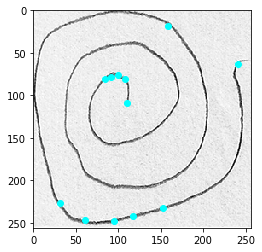

[[ 19 159]
 [ 63 241]
 [ 76 100]
 [ 78  92]
 [ 81  84]
 [ 81 108]
 [109 111]
 [227  31]
 [233 153]
 [242 118]
 [247  61]
 [248  95]]


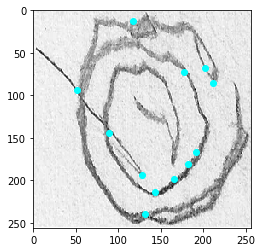

[[ 13 117]
 [ 68 202]
 [ 73 178]
 [ 85 212]
 [ 94  52]
 [144  89]
 [167 192]
 [181 182]
 [194 128]
 [198 166]
 [214 143]
 [240 132]]


"\ncv2.imshow('image',healthy)\ncv2.waitKey(0)\ncv2.destroyAllWindows()\n"

In [42]:
from skimage.feature import corner_harris, corner_subpix, corner_peaks
from skimage.io import imread
from skimage.color import rgb2gray

healthy_path = 'C:\\Users\\Daniel\\Documents\\School\\CMPT 399 Machine Learning\\Project\\parkinsons-drawings\\spiral\\training\\healthy\\V01HE02.png'
park_path = 'C:\\Users\\Daniel\\Documents\\School\\CMPT 399 Machine Learning\\Project\\parkinsons-drawings\\spiral\\training\\parkinson\\V04PE02.png'

healthy = imread(healthy_path)

coords = corner_peaks(corner_harris(healthy), min_distance=7)
coords_subpix = corner_subpix(healthy, coords, window_size=13)

fig, ax = plt.subplots()
ax.imshow(healthy, cmap=plt.cm.gray)
ax.plot(coords[:,1],coords[:,0], color='cyan', marker='o',linestyle='None',markersize=6)
ax.axis((0,256,256,0))
plt.show()

print(coords)

parkinson = imread(park_path)

coords = corner_peaks(corner_harris(parkinson), min_distance=11)
coords_subpix = corner_subpix(parkinson, coords, window_size=13)

fig, ax = plt.subplots()
ax.imshow(parkinson, cmap=plt.cm.gray)
ax.plot(coords[:,1],coords[:,0], color='cyan', marker='o',linestyle='None',markersize=6)
ax.axis((0,256,256,0))
plt.show()

print(coords)

'''
cv2.imshow('image',healthy)
cv2.waitKey(0)
cv2.destroyAllWindows()
'''

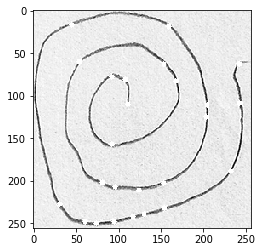

In [43]:
healthy = cv2.imread(healthy_path,0)

corners = cv2.goodFeaturesToTrack(healthy,25,0.01,10)
corners = np.int0(corners)

for i in corners:
    x,y = i.ravel()
    cv2.circle(healthy,(x,y),3,255,-1)
    
plt.imshow(healthy, cmap=plt.cm.gray)
plt.show()

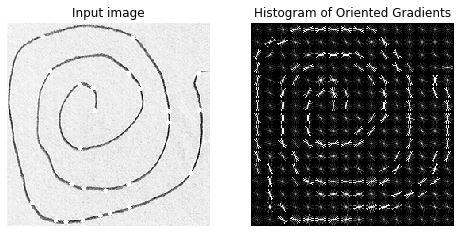

(16, 16, 1, 1, 8)


In [30]:
from skimage.feature import hog
from skimage import exposure

fd, hog_image = hog(healthy,orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualize=True, multichannel=False, feature_vector=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(healthy, cmap=plt.cm.gray)
ax1.set_title('Input image')

hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

print(np.shape(fd))